In [1]:
import multiprocessing
import os
from re import A
from typing import ItemsView

from py import log
os.environ['PYTHONDONTWRITEBYTECODE'] = '1'
from xtquant import xttrader
from xtquant.xttrader import XtQuantTrader, XtQuantTraderCallback
from xtquant.xttype import StockAccount
from xtquant import xtconstant
import pandas_market_calendars as mcal
import pandas as pd
import akshare as ak

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
def plot(df, column):
    
    # 设置中文字体
    mpl.rcParams['font.sans-serif'] = ['SimHei']  # 指定中文字体为 SimHei
    mpl.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

    # 假设这是你的DataFrame，其中包含收益

    # 绘制收益曲线
    # 将日期列转换为日期类型
    # df['date'] = pd.to_datetime(df['date'])

    # # 设置日期列为索引
    # df.set_index('date', inplace=True)
    df.index = pd.to_datetime(df.index)
    # 绘制收益曲线
    plt.figure(figsize=(10, 6))  # 设置图表大小
    plt.plot(df.index, df[column], label='Return')
    plt.title('收益曲线')
    plt.xlabel('日期')
    plt.ylabel('收益率')
    plt.legend()  # 显示图例
    plt.grid(True)  # 显示网格线

    # plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    # plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))

    plt.show()

d:\anaconda3\envs\python3.8\lib\site-packages\exchange_calendars\exchange_calendar.py:2345: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  align: pd.Timedelta | str = pd.Timedelta(1, "T"),


In [2]:
from xtquant import xtdatacenter as xtdc
xtdc.set_token("26e6009f4de3bfb2ae4b89763f255300e96d6912")

print('xtdc.init')
xtdc.init() # 初始化行情模块，加载合约数据，会需要大约十几秒的时间
print('done')

from xtquant import xtdata 

xtdc.init
done


In [3]:
import sys
sys.path.append(r"D:\workspace\TradeX\ezMoney")
from http_request import build_http_request
from data_class import category_rank_class
def get_ranked_category_infos(date_key, except_is_ppp = True, except_is_track = False, gap = 10):
    # build_http_request.check_user_alive()
    categoryRankList = category_rank_class.build_category_rank_sort_list(date_key)
    block_rank_list = []
    for item in categoryRankList:
        if item == None:
            continue
        if item.stockType == 'industry':
            isPpp = item.isPpp
            num = item.num
            numChange = item.numChange
            isTrack = item.isTrack
            stockCode = item.categoryCode
            r  = {
                'isPpp': isPpp,
                'num': num,
                'numChange': numChange,
                'isTrack': isTrack,
                'blockCode': stockCode
            }
            block_rank_list.append(r)
        if item.blockRankList == None:
            continue
        block_rank_list.extend(item.blockRankList)

    if except_is_ppp:
        block_rank_list = [item for item in block_rank_list if not item['isPpp']]
    if except_is_track:
        block_rank_list = [item for item in block_rank_list if not item['isTrack']]

    sorted_block_rank_list = sorted(block_rank_list, key=lambda x: (-x['num'], -x['numChange']))
    rank_dict = {}
    prev_num = None
    current_rank = 1

    for idx, item in enumerate(sorted_block_rank_list):
        code = item['blockCode']
        num = item['num']

        if idx == 0:
            # 第一个元素直接赋初始排名
            rank_dict[code] = current_rank
            prev_num = num
            continue

        delta = 0
        diff = prev_num - num

        # 判断差值规则
        if abs(diff) <= 0.0001:
            delta = 0
        else:
            if gap == 0:
                delta = 1
            else:
                if diff > gap:
                    delta = int(diff // gap) + 1
                else:
                    delta = 1
        current_rank += delta
        rank_dict[code] = current_rank
        prev_num = num
    return rank_dict

In [4]:


hd_pct = 0.001

strategy_name = '连断低吸'
days = 2
#胜率最高
# params = [
#               {
#         "filtered": True,
#         "fx_filtered": True,
#         "topn": 1,
#         "top_fx": 2,
#         "top_cx": 1,
#         "only_fx": True,
#         "enbale_industry": True,
#         "empty_priority": True
#       },
      
#         ]

params = [
              {
        "filtered": True,
        "fx_filtered": True,
        "topn": 1,
        "top_fx": 2,
        "top_cx": 50,
        "only_fx": True,
        "enbale_industry": False,
        "empty_priority": False
      },
      
        ]

filter_count = 0
filter_amount = 6000000
gap = 0
rank_filter = True

In [5]:
def get_first_tick_trade_amount(stock_code, datekey):
    import datetime
    import pandas as pd

    today = datetime.datetime.strptime(datekey, '%Y-%m-%d').date()

    time_0930 = datetime.time(9, 20, 0)

    dt_0930 = datetime.datetime.combine(today, time_0930)

    timestamp_0930 = dt_0930.timestamp()

    time_09305 = datetime.time(9, 26, 0)

    dt_09305 = datetime.datetime.combine(today, time_09305)

    timestamp_09305 = dt_09305.timestamp()

    tims = int(timestamp_0930*1000)

    tims5 = int(timestamp_09305*1000)
    import numpy as np
    n_data_key = datekey.replace('-', '')
    xtdata.download_history_data(stock_code, 'tick', n_data_key, n_data_key)
    all_tick_data = xtdata.get_market_data(stock_list=[stock_code], period='tick', start_time=n_data_key, end_time=n_data_key)

    # 假设 all_tick_data['000759.SZ'] 是 numpy.void 数组
    if isinstance(all_tick_data[stock_code], np.ndarray) and all_tick_data[stock_code].dtype.type is np.void:
        df = pd.DataFrame(all_tick_data[stock_code].tolist(), columns=all_tick_data[stock_code].dtype.names)
    else:
        raise

    filtered_df = df[(df['time'] >= tims) & (df['time'] <= tims5)]

    # 按 time 列升序排序
    sorted_df = filtered_df.sort_values(by='time')

    # 取 time 最小的行
    min_time_row = sorted_df.tail(1)

    amount = min_time_row['amount']

    if len(amount) == 1:
        real_amount = amount.item()
    else:
        print(f"{stock_code}-{datekey}")
        real_amount = 0

    return real_amount

def get_real_open_price(stock_code, datekey):
    import datetime

    today = datetime.datetime.strptime(datekey, '%Y-%m-%d').date()

    time_0930 = datetime.time(9, 29, 0)

    dt_0930 = datetime.datetime.combine(today, time_0930)

    timestamp_0930 = dt_0930.timestamp()

    time_09305 = datetime.time(9, 30, 5)

    dt_09305 = datetime.datetime.combine(today, time_09305)

    timestamp_09305 = dt_09305.timestamp()

    tims = int(timestamp_0930*1000)

    tims5 = int(timestamp_09305*1000)
    import numpy as np
    n_data_key = datekey.replace('-', '')
    xtdata.download_history_data(stock_code, 'tick', n_data_key, n_data_key)
    all_tick_data = xtdata.get_market_data(stock_list=[stock_code], period='tick', start_time=n_data_key, end_time=n_data_key)

    # 假设 all_tick_data['000759.SZ'] 是 numpy.void 数组
    if isinstance(all_tick_data[stock_code], np.ndarray) and all_tick_data[stock_code].dtype.type is np.void:
        df = pd.DataFrame(all_tick_data[stock_code].tolist(), columns=all_tick_data[stock_code].dtype.names)
    else:
        raise

    filtered_df = df[(df['time'] >= tims) & (df['time'] <= tims5)]

    # 按 time 列升序排序
    sorted_df = filtered_df.sort_values(by='time')

    # 取 time 最小的行
    min_time_row = sorted_df.head(1)

    last_price = min_time_row['lastPrice']

    # 检查 Series 是否只有一个元素
    if len(last_price) == 1:
        last_price_real = last_price.item()
    else:
        print(f"{stock_code}-{datekey}")
        last_price_real = -1

    return last_price_real

In [ ]:
all_stocks = {}
all_stocks_info = xtdata.get_stock_list_in_sector('沪深A股')
for stock in all_stocks_info:
    if stock.startswith('60') or stock.startswith('00'):
        cde = stock.split('.')[0]
        all_stocks[cde] = stock

def group_filter_fx(group, filtered = True, fx_filtered = True, topn = 3, top_fx = 2, top_cx = 2, only_fx = False, enbale_industry= False, filter_amount = filter_amount, all_stocks = all_stocks):
    if filter_amount > 0:
        masks = []
        first_tick_amounts = []  # 存储每行的 first_tick_amount
        
        # 遍历每一行并计算值
        for _, row in group.iterrows():
            if row['stock_code'].split('.')[0] not in all_stocks:
                masks.append(False)
                first_tick_amounts.append(0)
                continue
            stock_code = all_stocks[row['stock_code'].split('.')[0]]
            date_key = row['date_key']
                
            # 计算 first_tick_amount
            first_tick_amount = get_first_tick_trade_amount(stock_code, date_key)
            first_tick_amounts.append(first_tick_amount)  # 记录值
            if first_tick_amount > filter_amount:
                masks.append(True)
            else:
                print(f"过滤股票 {stock_code} 日期 {date_key} 过滤原因： first_tick_amount {first_tick_amount}")
                masks.append(False)
                global filter_count
                filter_count = filter_count + 1
            # 生成过滤掩码
        
        # 将 first_tick_amount 添加到原始分组中
        group = group.copy()  # 避免 SettingWithCopyWarning
        group['first_tick_amount'] = first_tick_amounts
        
        # 应用过滤
        group = group[masks]
            
    if not filtered:
        valid_rows = group[(group['open_price'] > 0) & (group['next_day_open_price'] > 0) & (group['stock_rank'] <= topn) & (group['next_day_close_price'] > 0)]
        if len(valid_rows) > 0:
            valid_rows['return'] = valid_rows['next_day_open_price'] / valid_rows['open_price'] - 1
            valid_rows['real_return'] = valid_rows['return'] - hd_pct
            valid_rows['close_return'] = valid_rows['next_day_close_price'] / valid_rows['open_price'] - 1
            valid_rows['close_real_return'] = valid_rows['close_return'] - hd_pct
            avg_value = valid_rows['return'].mean()
            close_avg_value = valid_rows['close_return'].mean()
            rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
            if len(rank_one_row) > 0:
                # 将平均值赋给 rank 为 1 的行的指定列
                rank_one_row['return'] = avg_value
                rank_one_row['real_return'] = avg_value - hd_pct
                rank_one_row['close_return'] = close_avg_value
                rank_one_row['close_real_return'] = close_avg_value - hd_pct
                return rank_one_row
        else:
            rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
            if len(rank_one_row) > 0:
                rank_one_row['return'] = -10
                rank_one_row['real_return'] = -10
                rank_one_row['close_return'] = -10
                rank_one_row['close_real_return'] = -10
                return rank_one_row
    else:
        if fx_filtered:
            min_category_rank = group['max_block_category_rank'].min()
            
            industry_rank_one_row = group[group['max_industry_code_rank'] == 1].copy()
            if not industry_rank_one_row.empty and len(industry_rank_one_row) == 1 and enbale_industry:
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row
            elif not industry_rank_one_row.empty and len(industry_rank_one_row) > 1 and enbale_industry:
                industry_rank_one_row = industry_rank_one_row[industry_rank_one_row['stock_rank'] == industry_rank_one_row['stock_rank'].min()]
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row

            if min_category_rank > top_fx:
                if only_fx:
                    return group[group['max_block_category_rank'] < min_category_rank]
                rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
                if len(rank_one_row) > 0:
                    rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                    rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                    return rank_one_row
            else:
                category_filtered = group[(group['max_block_category_rank'] <= top_fx) & ((group['max_block_code_rank'] <= top_cx) | (group['max_industry_code_rank'] <= top_cx))]
                if len(category_filtered) == 0:
                    if only_fx:
                        return group[group['max_block_category_rank'] < min_category_rank]
                    rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
                    if not rank_one_row.empty and len(rank_one_row) > 0:
                        rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                        rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                    return rank_one_row

                result = category_filtered[category_filtered['max_block_code_rank'] == category_filtered['max_block_code_rank'].min()]
                if len(result) > 1:
                    result = result[result['stock_rank'] == result['stock_rank'].min()]
                result['return'] = result['next_day_open_price'] / result['open_price'] - 1
                result['real_return'] = result['return'] - hd_pct
                result['close_return'] = result['next_day_close_price'] / result['open_price'] - 1
                result['close_real_return'] = result['close_return'] - hd_pct
                return result
        else:
            rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
            if not rank_one_row.empty and len(rank_one_row) > 0:
                rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
            return rank_one_row



def group_filter(group, filtered = True, fx_filtered = True, topn = 3, top_fx = 2, top_cx = 2, only_fx = False, enbale_industry= False, filter_amount = filter_amount, all_stocks = all_stocks):
    if filter_amount > 0:
        masks = []
        first_tick_amounts = []  # 存储每行的 first_tick_amount
        
        # 遍历每一行并计算值
        for _, row in group.iterrows():
            if row['stock_code'].split('.')[0] not in all_stocks:
                masks.append(False)
                first_tick_amounts.append(0)
                continue
            stock_code = all_stocks[row['stock_code'].split('.')[0]]
            date_key = row['date_key']
            # 计算 first_tick_amount
            first_tick_amount = get_first_tick_trade_amount(stock_code, date_key)
            first_tick_amounts.append(first_tick_amount)  # 记录值
            if first_tick_amount > filter_amount:
                masks.append(True)
            else:
                print(f"过滤股票 {stock_code} 日期 {date_key} 过滤原因： first_tick_amount {first_tick_amount}")
                masks.append(False)
                global filter_count
                filter_count = filter_count + 1
            # 生成过滤掩码
        
        # 将 first_tick_amount 添加到原始分组中
        group = group.copy()  # 避免 SettingWithCopyWarning
        group['first_tick_amount'] = first_tick_amounts
        
        # 应用过滤
        group = group[masks]
    if not filtered:
        valid_rows = group[(group['open_price'] > 0) & (group['next_day_open_price'] > 0) & (group['stock_rank'] <= topn) & (group['next_day_close_price'] > 0)]
        if len(valid_rows) > 0:
            valid_rows['return'] = valid_rows['next_day_open_price'] / valid_rows['open_price'] - 1
            valid_rows['real_return'] = valid_rows['return'] - hd_pct
            valid_rows['close_return'] = valid_rows['next_day_close_price'] / valid_rows['open_price'] - 1
            valid_rows['close_real_return'] = valid_rows['close_return'] - hd_pct
            avg_value = valid_rows['return'].mean()
            close_avg_value = valid_rows['close_return'].mean()
            rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
            if len(rank_one_row) > 0:
                # 将平均值赋给 rank 为 1 的行的指定列
                rank_one_row['return'] = avg_value
                rank_one_row['real_return'] = avg_value - hd_pct
                rank_one_row['close_return'] = close_avg_value
                rank_one_row['close_real_return'] = close_avg_value - hd_pct
                return rank_one_row
        else:
            rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
            if len(rank_one_row) > 0:
                rank_one_row['return'] = -10
                rank_one_row['real_return'] = -10
                rank_one_row['close_return'] = -10
                rank_one_row['close_real_return'] = -10
                return rank_one_row
    else:
        if fx_filtered:
            min_category_rank = group['max_block_category_rank'].min()

            industry_rank_one_row = group[group['max_industry_code_rank'] == 1].copy()
            if not industry_rank_one_row.empty and len(industry_rank_one_row) == 1 and enbale_industry:
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row
            elif not industry_rank_one_row.empty and len(industry_rank_one_row) > 1 and enbale_industry:
                industry_rank_one_row = industry_rank_one_row[industry_rank_one_row['stock_rank'] == industry_rank_one_row['stock_rank'].min()]
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row
            
            if min_category_rank > top_fx:
                if only_fx:
                    return group[group['max_block_category_rank'] < min_category_rank]
                rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
                if len(rank_one_row) > 0:
                    rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                    rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                    return rank_one_row
            elif min_category_rank < 0:
                category_filtered = group[(group['max_block_category_rank'] > 0) & (group['max_block_category_rank'] <= top_fx) & (((group['max_block_code_rank'] <= top_cx) & (group['max_block_code_rank'] > 0)) | ((group['max_industry_code_rank'] <= top_cx) & (group['max_industry_code_rank'] > 0)))]
                if not category_filtered.empty and len(category_filtered) > 0:
                    category_filtered = category_filtered[category_filtered['stock_rank'] == category_filtered['stock_rank'].min()]
                    category_filtered['return'] = category_filtered['next_day_open_price'] / category_filtered['open_price'] - 1
                    category_filtered['real_return'] = category_filtered['return'] - hd_pct
                    category_filtered['close_return'] = category_filtered['next_day_close_price'] / category_filtered['open_price'] - 1
                    category_filtered['close_real_return'] = category_filtered['close_return'] - hd_pct
                    return category_filtered
                else:
                    rank_one_row = group[group['max_block_category_rank'] == min_category_rank]
                    if len(rank_one_row) > 0:
                        rank_one_row = rank_one_row[rank_one_row['stock_rank'] == rank_one_row['stock_rank'].min()].copy()
                        if not rank_one_row.empty and len(rank_one_row) > 0:
                            rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                            rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                            rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                            rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                            return rank_one_row
                    if only_fx:
                        return group[group['max_block_category_rank'] < min_category_rank]
                    rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
                    if not rank_one_row.empty and len(rank_one_row) > 0:
                        rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                        rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                        return rank_one_row
                    else:
                        raise Exception("No data.")
            else:
                result = group[(group['max_block_category_rank'] > 0) & (group['max_block_category_rank'] <= top_fx) & (((group['max_block_code_rank'] <= top_cx) & (group['max_block_code_rank'] > 0)) | ((group['max_industry_code_rank'] <= top_cx) & (group['max_industry_code_rank'] > 0)))]
                
                if result.empty or len(result) < 1:
                    if only_fx:
                        return group[group['max_block_category_rank'] < min_category_rank]
                    rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
                    if not rank_one_row.empty and len(rank_one_row) > 0:
                        rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                        rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                        return rank_one_row
                if len(result) > 1:
                    result = result[result['stock_rank'] == result['stock_rank'].min()]
                result['return'] = result['next_day_open_price'] / result['open_price'] - 1
                result['real_return'] = result['return'] - hd_pct
                result['close_return'] = result['next_day_close_price'] / result['open_price'] - 1
                result['close_real_return'] = result['close_return'] - hd_pct
                return result
        else:
            rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
            if not rank_one_row.empty and len(rank_one_row) > 0:
                rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
            return rank_one_row


***** xtdata连接成功 *****
服务信息: {'tag': 'xtquant', 'version': '1.0'}
服务地址: 127.0.0.1:58609
数据路径: d:\workspace\TradeX\notebook\data\datadir
设置xtdata.enable_hello = False可隐藏此消息



In [7]:
param0 = params[0]
empty_priority = param0['empty_priority']
del param0['empty_priority']
if empty_priority:
    filter_func = group_filter_fx
else:
    filter_func = group_filter

In [8]:
import sqlite3
# months = ['202502']
months = ['202409', '202410', '202411', '202412', '202501', '202502', '202503']
# months = ['202409', '202410']
combined_df = pd.DataFrame()
for month in months:
    conn = sqlite3.connect('D:\workspace\TradeX\ezMoney\sqlite_db\strategy_data.db')
    db_name = 'strategy_data_aftermarket_%s' % month
    query = "select * from %s where (sub_strategy_name = '%s') and stock_rank <= %s " % (db_name, strategy_name, days)
    df = pd.read_sql_query(query, conn)
    combined_df = pd.concat([combined_df, df], axis=0)
combined_df = combined_df.reset_index(drop=True)
combined_df

,id,date_key,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,...,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,env_json_info,block_category_info,created_at
0,940,2024-09-03,低吸,连断低吸,002426.XSHE,胜利精密,1,"000038.BKDL,000026.BKDL,000014.BKDL,000035.BKD...","885785.DDBK,885840.DDBK,885467.DDBK,886000.DDB...","980365.ZHBK,980357.ZHBK",...,连断低吸,-95.63,9.09,71,-104.94,2.01,66,"{""9A0001"": {""realShortLineScore"": 20.72, ""real...","{""000028.BKDL"": {""categoryCode"": ""000028.BKDL""...",2025-02-15 17:42:44
1,941,2024-09-03,低吸,连断低吸,600543.XSHG,莫高股份,2,,,,...,连断低吸,-95.63,9.09,71,-104.94,2.01,66,"{""9A0001"": {""realShortLineScore"": 20.72, ""real...","{""000028.BKDL"": {""categoryCode"": ""000028.BKDL""...",2025-02-15 17:42:44
2,974,2024-09-04,低吸,连断低吸,002514.XSHE,宝馨科技,1,"000038.BKDL,000035.BKDL,000023.BKDL,000018.BKD...","885878.DDBK,885739.DDBK,885930.DDBK,885517.DDB...",980365.ZHBK,...,连断低吸,-54.31,41.32,61,-92.66,4.00,62,"{""9A0001"": {""realShortLineScore"": 26.55, ""real...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-02-15 17:43:47
3,1022,2024-09-05,低吸,连断低吸,603004.XSHG,鼎龙科技,1,"000036.BKDL,000026.BKDL,000022.BKDL,000032.BKD...","885840.DDBK,885598.DDBK,885929.DDBK,885905.DDB...",980364.ZHBK,...,连断低吸,-39.29,15.02,41,-87.03,-2.07,55,"{""9A0001"": {""realShortLineScore"": -12.1, ""real...","{""000003.BKDL"": {""categoryCode"": ""000003.BKDL""...",2025-02-15 17:44:51
4,1023,2024-09-05,低吸,连断低吸,000859.XSHE,国风新材,2,"000038.BKDL,000036.BKDL,000027.BKDL,000031.BKD...","885694.DDBK,886021.DDBK,885809.DDBK,885431.DDB...",980364.ZHBK,...,连断低吸,-39.29,15.02,41,-87.03,-2.07,55,"{""9A0001"": {""realShortLineScore"": -12.1, ""real...","{""000003.BKDL"": {""categoryCode"": ""000003.BKDL""...",2025-02-15 17:44:51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,2464,2025-03-18,低吸,连断低吸,002105.XSHE,信隆健康,1,"000012.BKDL,000021.BKDL,000026.BKDL,000014.BKD...","885785.DDBK,885840.DDBK,885420.DDBK,885522.DDB...",980372.ZHBK,...,连断低吸,-120.18,-156.25,69,-90.65,-22.71,71,"{""9A0001"": {""realShortLineScore"": 51.82, ""real...","{""000038.BKDL"": {""categoryCode"": ""000038.BKDL""...",2025-03-19 08:00:42
209,2602,2025-03-19,低吸,连断低吸,603238.XSHG,诺邦股份,1,"000021.BKDL,000026.BKDL,000023.BKDL,000010.BKDL","885869.DDBK,885840.DDBK,885420.DDBK,885540.DDBK",980477.ZHBK,...,连断低吸,-112.47,-41.52,59,-93.02,-19.32,69,"{""9A0001"": {""realShortLineScore"": 39.04, ""real...","{""000038.BKDL"": {""categoryCode"": ""000038.BKDL""...",2025-03-20 08:00:45
210,2603,2025-03-19,低吸,连断低吸,002329.XSHE,皇氏集团,2,"000012.BKDL,000038.BKDL,000026.BKDL,000035.BKD...","885338.DDBK,885936.DDBK,885780.DDBK,886006.DDB...",,...,连断低吸,-112.47,-41.52,59,-93.02,-19.32,69,"{""9A0001"": {""realShortLineScore"": 39.04, ""real...","{""000038.BKDL"": {""categoryCode"": ""000038.BKDL""...",2025-03-20 08:00:45
211,2652,2025-03-20,低吸,连断低吸,000905.XSHE,厦门港务,1,"000038.BKDL,000026.BKDL,000018.BKDL,000010.BKD...","885338.DDBK,883436.DDBK,886021.DDBK,885694.DDB...",980339.ZHBK,...,连断低吸,-90.26,15.39,53,-71.97,18.10,57,"{""9B0002"": {""realShortLineScore"": 28.86, ""real...","{""000033.BKDL"": {""categoryCode"": ""000033.BKDL""...",2025-03-20 08:01:37


In [9]:
if rank_filter:
    for idx, row in combined_df.iterrows():
        block_category = row['block_category']
        block_codes = row['block_codes']
        industry_code = row['industry_code']
        date_key = row['date_key']
        ranked_block_dict = get_ranked_category_infos(date_key, gap = gap)
        min_rank = 100
        if not block_codes:
            continue
        else:
            for block_code in block_codes.split(','):
                if block_code in ranked_block_dict:
                    rank_this = ranked_block_dict[block_code]
                    min_rank = min(min_rank, rank_this)
        if not industry_code:
            combined_df.loc[idx, 'max_block_code_rank'] = min_rank
            continue
        else:
            i_min_rank = 100
            for i_code in industry_code.split(','):
                if i_code in ranked_block_dict:
                    rank_this = ranked_block_dict[i_code]
                    min_rank = min(min_rank, rank_this)
                    i_min_rank = min(i_min_rank, rank_this)
                    combined_df.loc[idx, 'max_industry_code_rank'] = i_min_rank
            combined_df.loc[idx, 'max_block_code_rank'] = min_rank


In [10]:
combined_df = combined_df.reset_index(drop=True)

In [11]:
combined_df = combined_df.drop(['env_json_info', 'block_category_info'], axis=1)
combined_df = combined_df[combined_df['strategy_name'] == '低吸']

In [12]:
pd.set_option('display.max_columns', None)
combined_df.tail(10)

,id,date_key,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,created_at
203,1963,2025-03-13,低吸,连断低吸,605100.XSHG,华丰股份,2,"000003.BKDL,000024.BKDL,000023.BKDL,000035.BKD...","885869.DDBK,885887.DDBK,885706.DDBK,885946.DDB...",980365.ZHBK,1,7,17,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,0.0,399.97,383.09,0.0,-1.97,27.84,31.24,-1.0,30.00,28.63,-1.0,-1.0,-1.0,-1.0,0,0,9G0033,连断低吸,70.64,-17.14,14,-19.87,12.62,37,2025-03-14 08:00:52
204,2122,2025-03-14,低吸,连断低吸,000665.XSHE,湖北广电,1,"000012.BKDL,000003.BKDL,000038.BKDL,000023.BKD...","885338.DDBK,886021.DDBK,885749.DDBK,886041.DDB...","980355.ZHBK,980348.ZHBK",1,9,21,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0.0,120.56,198.56,0.0,-7.16,7.00,6.89,-1.0,6.89,6.38,-1.0,-1.0,-1.0,-1.0,0,0,9G0033,连断低吸,89.93,-1.09,14,-34.70,-22.11,40,2025-03-17 08:00:47
205,2123,2025-03-14,低吸,连断低吸,603958.XSHG,哈森股份,2,"000010.BKDL,000034.BKDL,000033.BKDL","886100.DDBK,885420.DDBK,885941.DDBK,885784.DDBK",,4,1,-1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0.0,104.22,241.85,0.0,-6.13,18.52,17.76,-1.0,16.69,16.73,-1.0,-1.0,-1.0,-1.0,0,0,9G0033,连断低吸,89.93,-1.09,14,-34.70,-22.11,40,2025-03-17 08:00:47
206,2320,2025-03-17,低吸,连断低吸,603206.XSHG,嘉环科技,1,"000012.BKDL,000003.BKDL,000035.BKDL,000011.BKD...","886100.DDBK,885919.DDBK,885461.DDBK,885956.DDB...","980753.ZHBK,980376.ZHBK",2,6,11,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0.0,471.70,299.20,0.0,-2.71,21.50,21.01,-1.0,21.01,20.51,-1.0,-1.0,-1.0,-1.0,0,0,9G0033,连断低吸,59.51,-26.09,31,-59.29,-22.24,55,2025-03-18 08:00:43
207,2321,2025-03-17,低吸,连断低吸,603618.XSHG,杭电股份,2,"000038.BKDL,000035.BKDL,000004.BKDL,000001.BKD...","885743.DDBK,885338.DDBK,886084.DDBK,885425.DDB...",980474.ZHBK,1,10,25,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0.0,66.52,211.78,0.0,-1.87,8.40,8.22,-1.0,8.38,8.04,-1.0,-1.0,-1.0,-1.0,0,0,9G0033,连断低吸,59.51,-26.09,31,-59.29,-22.24,55,2025-03-18 08:00:43
208,2464,2025-03-18,低吸,连断低吸,002105.XSHE,信隆健康,1,"000012.BKDL,000021.BKDL,000026.BKDL,000014.BKD...","885785.DDBK,885840.DDBK,885420.DDBK,885522.DDB...",980372.ZHBK,7,11,20,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0.0,979.98,559.95,0.0,-0.77,11.60,11.74,-1.0,11.15,10.65,-1.0,-1.0,-1.0,-1.0,0,0,9G0033,连断低吸,-120.18,-156.25,69,-90.65,-22.71,71,2025-03-19 08:00:42
209,2602,2025-03-19,低吸,连断低吸,603238.XSHG,诺邦股份,1,"000021.BKDL,000026.BKDL,000023.BKDL,000010.BKDL","885869.DDBK,885840.DDBK,885420.DDBK,885540.DDBK",980477.ZHBK,4,14,100,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0.0,138.57,299.54,0.0,-1.83,15.06,16.87,-1.0,16.88,16.22,-1.0,-1.0,-1.0,-1.0,0,0,9G0033,连断低吸,-112.47,-41.52,59,-93.02,-19.32,69,2025-03-20 08:00:45
210,2603,2025-03-19,低吸,连断低吸,002329.XSHE,皇氏集团,2,"000012.BKDL,000038.BKDL,000026.BKDL,000035.BKD...","885338.DDBK,885936.DDBK,885780.DDBK,886006.DDB...",,1,9,-1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0.0,136.22,254.16,0.0,-4.76,3.80,3.83,-1.0,3.81,3.86,-1.0,-1.0,-1.0,-1.0,0,0,9G0033,连断低吸,-112.47,-41.52,59,-93.02,-19.32,69,2025-03-20 08:00:45
211,2652,2025-03-20,低吸,连断低吸,000905.XSHE,厦门港务,1,"000038.BKDL,000026.BKDL,000018.BKDL,000010.BKD...","885338.DDBK,883436.DDBK,886021.DDBK,885694.DDB...",980339.ZHBK,3,9,100,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,213.69,324.80,0.0,-2.33,-1.00,-1.00,-1.0,-1.00,-1.00,-1.0,-1.0,-1.0,-1.0,0,0,9G0033,连断低吸,-90.26,15.39,53,-71.97,18.1

In [13]:

combined_df = combined_df.groupby(['date_key', 'strategy_name', 'sub_strategy_name']).apply(filter_func, **param0).reset_index(drop=True)

# 将索引设置为 date_key 列
combined_df = combined_df.set_index('date_key')

# 对索引进行排序
combined_df = combined_df.sort_index()


combined_df

过滤股票 600543.SH 日期 2024-09-03 过滤原因： first_tick_amount 5643840.0
过滤股票 000020.SZ 日期 2024-09-06 过滤原因： first_tick_amount 5183584.0
过滤股票 603616.SH 日期 2024-10-10 过滤原因： first_tick_amount 4495988.0


KeyError: '600225'

In [ ]:
from xtquant import xtdata
import time
import pandas as pd

all_stocks = {}
all_stocks_info = xtdata.get_stock_list_in_sector('沪深A股')
for stock in all_stocks_info:
    if stock.startswith('60') or stock.startswith('00'):
        cde = stock.split('.')[0]
        all_stocks[cde] = stock
for i in range(1, 11):
    combined_df[f'close_{i}'] = -1
    combined_df[f'low_{i}'] = -1
combined_df['real_open'] = -1
for date_key, row in combined_df.iterrows():
    stock_code = row['stock_code']
    stock_code = all_stocks[stock_code.split('.')[0]]
    n_data_key = date_key
    if '-' in n_data_key:
        n_data_key = n_data_key.replace('-', '')
    # xtdata.download_history_data(stock_code, '1m', n_data_key, n_data_key)
    # all_data = xtdata.get_market_data(stock_list=[stock_code], period='1m', start_time=n_data_key, end_time=n_data_key)

    # df = pd.DataFrame()
    # for key in all_data.keys():
    #     ndf = all_data[key].T
    #     ndf = ndf.sort_index()
    #     ndf.columns = [key]
    #     df = pd.concat([df, ndf], axis=1)
    
    # i = 1
    # for idx, rrow in df[1:11].iterrows():
    #     combined_df.loc[date_key, f'close_{i}'] = rrow['close']
    #     combined_df.loc[date_key, f'low_{i}'] = rrow['low']
    #     i += 1
    real_open_price = get_real_open_price(stock_code, date_key)
    combined_df.loc[date_key, 'real_open'] = real_open_price

C:\Users\Administrator\AppData\Local\Temp\ipykernel_18592\1308428503.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.83' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  combined_df.loc[date_key, 'real_open'] = real_open_price


In [ ]:
combined_df[['open_price', 'next_day_close_price', 'low_1', 'low_2', 'low_3', 'low_4', 'low_5', 'low_6', 'low_7', 'low_8', 'low_9', 'low_10']]

,open_price,next_day_close_price,low_1,low_2,low_3,low_4,low_5,low_6,low_7,low_8,low_9,low_10
date_key,,,,,,,,,,,,
2024-09-03,1.80,1.78,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-09-09,6.31,5.56,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-09-30,6.06,7.34,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-10-11,9.11,9.21,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-10-24,3.63,4.81,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-10-25,5.38,6.51,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-11-04,13.38,14.43,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-11-06,13.50,12.02,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-11-08,17.34,17.79,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [ ]:
# combined_df['avg_close'] = 0
# for i in range(1, 11):
#     combined_df['avg_close'] += combined_df['close_%s' % i]
# combined_df['avg_close'] = combined_df['avg_close'] / 10
dwndx = combined_df[combined_df['open_price'] > 0]
ddwndx = dwndx

In [ ]:
ddwndx

,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,created_at,first_tick_amount,return,real_return,close_return,close_real_return,close_1,low_1,close_2,low_2,close_3,low_3,close_4,low_4,close_5,low_5,close_6,low_6,close_7,low_7,close_8,low_8,close_9,low_9,close_10,low_10,real_open
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-09-03,940,低吸,连断低吸,002426.XSHE,胜利精密,1,"000038.BKDL,000026.BKDL,000014.BKDL,000035.BKD...","885785.DDBK,885840.DDBK,885467.DDBK,886000.DDB...","980365.ZHBK,980357.ZHBK",4,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,126.02,305.80,0.0,-4.76,1.80,1.84,-1.0,1.80,1.78,-1.0,-1.0,-1.0,-1.0,0,0,9G0033,连断低吸,-95.63,9.09,71,-104.94,2.01,66,2025-02-15 17:42:44,28394100.0,0.000000,-0.001000,-0.011111,-0.012111,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1.83
2024-09-09,1118,低吸,连断低吸,600829.XSHG,人民同泰,1,"000006.BKDL,000004.BKDL,000009.BKDL","885490.DDBK,885502.DDBK,885879.DDBK,885539.DDB...","980345.ZHBK,980378.ZHBK",1,1,3,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,107.35,307.85,0.0,-2.77,6.31,5.89,-1.0,5.87,5.56,-1.0,-1.0,-1.0,-1.0,0,0,9G0033,连断低吸,-27.24,20.50,48,-84.42,-4.77,57,2025-02-15 17:47:03,14354304.0,-0.069731,-0.070731,-0.118859,-0.119859,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,6.35
2024-09-30,1636,低吸,连断低吸,002583.XSHE,海能达,1,"000008.BKDL,000026.BKDL,000018.BKDL,000023.BKD...","885840.DDBK,885757.DDBK,885521.DDBK,885574.DDB...",980376.ZHBK,1,1,67,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,879.55,515.26,0.0,0.00,6.06,6.67,-1.0,7.34,7.34,-1.0,-1.0,-1.0,-1.0,0,0,9G0033,连断低吸,126.97,0.71,4,124.59,3.76,10,2025-02-15 18:01:07,149229318.0,0.211221,0.210221,0.211221,0.210221,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,6.20
2024-10-11,242,低吸,连断低吸,600619.XSHG,海立股份,1,,,,-1,-1,-1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,186.87,274.16,0.0,-3.60,9.11,9.00,-1.0,8.88,9.21,-1.0,-1.0,-1.0,-1.0,0,0,9G0033,连断低吸,110.47,-13.15,6,129.15,-7.53,7,2025-02-15 18:05:18,55130749.0,-0.025247,-0.026247,0.010977,0.009977,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,9.04
2024-10-24,700,低吸,连断低吸,000016.XSHE,深康佳A,2,,,,-1,-1,-1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,169.66,307.79,0.0,-8.56,3.63,4.37,-1.0,4.81,4.81,-1.0,-1.0,-1.0,-1.0,0,0,9G0033,连断低吸,95.27,-19.03,18,144.35,-12.37,3,2025-02-15 18:15:56,35941719.0,0.325069,0.324069,0.325069,0.324069,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,3.70
2024-10-25,770,低吸,连断低吸,002676.XSHE,顺威股份,2,,,,-1,-1,-1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,72.93,199.65,0.0,0.00,5.38,5.92,-1.0,6.49,6.51,-1.0,-1.0,-1.0,-1.0,0,0,9G0033,连断低吸,117.54,22.27,4,156.44,1.44,1,2025-02-15 18:17:13,15918075.0,0.206320,0.205320,0.210037,0.209037,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,5.49
2024-11-04,268,低吸,连断低吸,600839.XSHG,四川长虹,2,,,,-1,-1,-1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0.0,497.02,432.02,0.0,-9.78,13.38,14.99,-1.0,14.50,14.43,-1.0,-1.0,-1.0,-1.0,0,0,9G0033,连断低吸,108.90,-26.76,4,165.53,-12.43,1,2025-02-15 18:25:21,799182704.0,0.083707,0.082707,0.078475,0.077475,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,13.43
2024-11-06,456,低吸,连断低吸,603809.XSHG,豪能股份,2,"000008.BKDL,000018.BKDL,000027.BKD

In [ ]:
def caculate_returns(returns_df, row, _print = False):
    r = {}
    cumulative_returns = (1 + returns_df[row]).cumprod()

    # 计算最大回撤
    cumulative_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()

    # 计算夏普比率
    risk_free_rate = 0.0  # 假设无风险利率为0
    sharpe_ratio = (returns_df[row].mean() - risk_free_rate) / returns_df[row].std()

    # 计算总收益率
    total_return = cumulative_returns.iloc[-1] - 1

    # 计算波动率
    volatility = returns_df[row].std()

    # 计算总盈亏
    total_profit_loss = cumulative_returns.iloc[-1] - cumulative_returns.iloc[0]

    # 计算成功次数、胜率、平均盈利、平均亏损、最大盈利、最大亏损以及盈亏比
    profitable_trades = returns_df[row][returns_df[row] > 0].count()
    losing_trades = returns_df[row][returns_df[row] < 0].count()
    win_rate = profitable_trades / (profitable_trades + losing_trades) if (profitable_trades + losing_trades) > 0 else 0
    average_profit = returns_df[row][returns_df[row] > 0].mean() if profitable_trades > 0 else 0
    average_loss = returns_df[row][returns_df[row] < 0].mean() if losing_trades > 0 else 0
    max_profit = returns_df[row].max()
    max_loss = returns_df[row].min()
    total_trades = profitable_trades + losing_trades
    total_times = returns_df[row].count()
    trade_pct = total_times / total_trades
    profit_loss_ratio = average_profit / abs(average_loss) if average_loss != 0 else 0
    kelly_fraction = win_rate - ((1 - win_rate) / profit_loss_ratio) if profit_loss_ratio != 0 else 0
    return_per_day = total_return / total_times
    year_return = return_per_day * 240

    r['最大回撤'] =  max_drawdown
    r['夏普比率'] =  sharpe_ratio
    r['总收益率'] =  total_return
    r['波动率'] = volatility
    r['年化收益率'] = year_return
    r['总盈亏'] = total_profit_loss
    r['成功次数'] = profitable_trades
    r['失败次数'] = losing_trades
    r['总天数'] = total_times
    r['总交易次数'] = total_trades
    r['交易频率'] = trade_pct
    r['胜率'] = win_rate
    r['平均盈利'] = average_profit
    r['平均亏损'] = average_loss
    r['最大盈利'] = max_profit
    r['最大亏损'] = max_loss
    r['盈亏比'] = profit_loss_ratio
    r['凯利公式最佳仓位'] = kelly_fraction
    if _print:
        print(f"最大回撤: {max_drawdown:.2%}")
        print(f"夏普比率: {sharpe_ratio:.2f}")
        print(f"总收益率: {total_return:.2%}")
        print(f"年化收益率: {year_return:.2%}")
        print(f"波动率: {volatility:.2%}")
        print(f"总盈亏: {total_profit_loss:.2%}")
        print(f"成功次数: {profitable_trades}")
        print(f"失败次数: {losing_trades}")
        print(f"总天数: {total_times}")
        print(f"总交易次数: {total_trades}")
        print(f"交易频率: {trade_pct:.2%}")
        print(f"胜率: {win_rate:.2%}")
        print(f"平均盈利: {average_profit:.2%}")
        print(f"平均亏损: {average_loss:.2%}")
        print(f"最大盈利: {max_profit:.2%}")
        print(f"最大亏损: {max_loss:.2%}")
        print(f"盈亏比: {profit_loss_ratio:.2f}")
        print(f"凯利公式最佳仓位: {kelly_fraction:.2%}")

    return r

In [ ]:

ddwndx['r_return'] = ddwndx['next_day_close_price']/ddwndx['real_open'] - 1
ddwndx['r_return'] = ddwndx['r_return']-0.001
ddwndx['cumulative_returns'] = (1 + ddwndx['r_return']).cumprod()
print("return:")
caculate_returns(ddwndx.tail(20), 'r_return', _print=True)
print('-----------------------------------------------------')

return:
最大回撤: -27.17%
夏普比率: 0.31
总收益率: 62.21%
年化收益率: 746.54%
波动率: 9.29%
总盈亏: 63.20%
成功次数: 13
失败次数: 7
总天数: 20
总交易次数: 20
交易频率: 100.00%
胜率: 65.00%
平均盈利: 8.77%
平均亏损: -8.12%
最大盈利: 15.90%
最大亏损: -12.06%
盈亏比: 1.08
凯利公式最佳仓位: 32.59%
-----------------------------------------------------


C:\Users\Administrator\AppData\Local\Temp\ipykernel_18592\4256206595.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ddwndx['r_return'] = ddwndx['next_day_close_price']/ddwndx['real_open'] - 1
C:\Users\Administrator\AppData\Local\Temp\ipykernel_18592\4256206595.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ddwndx['r_return'] = ddwndx['r_return']-0.001
C:\Users\Administrator\AppData\Local\Temp\ipykernel_18592\4256206595.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

: 

In [ ]:
ddwndx.tail(20)

,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,created_at,first_tick_amount,return,real_return,close_return,close_real_return,close_1,low_1,close_2,low_2,close_3,low_3,close_4,low_4,close_5,low_5,close_6,low_6,close_7,low_7,close_8,low_8,close_9,low_9,close_10,low_10,real_open,r_return,cumulative_returns,r_pct
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-12-26,1708,低吸,连断低吸,603207.XSHG,小方制药,1,,,980378.ZHBK,-1,-1,35,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,713.38,377.42,0.0,-2.26,29.00,29.67,-1.0,29.00,28.93,-1.0,-1.0,-1.0,-1.0,0,0,9G0033,连断低吸,-96.59,-5.54,68,-28.64,-9.26,41,2025-02-15 19:15:58,24171703.0,0.000000,-0.001000,-0.002414,-0.003414,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,29.19,-0.009907,0.856662,1.006552
2024-12-27,1784,低吸,连断低吸,600725.XSHG,云维股份,2,,,,-1,-1,-1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,255.26,338.52,0.0,-6.71,4.17,4.02,-1.0,3.79,3.68,-1.0,-1.0,-1.0,-1.0,0,0,9G0033,连断低吸,-76.12,20.47,56,-23.26,0.60,40,2025-02-15 19:17:10,43596808.0,-0.091127,-0.092127,-0.117506,-0.118506,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,4.18,-0.120617,0.753334,1.002398
2025-01-07,367,低吸,连断低吸,002397.XSHE,梦洁股份,1,,,,-1,-1,-1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0.0,773.22,513.57,0.0,-0.53,3.74,4.14,-1.0,4.11,4.02,-1.0,-1.0,-1.0,-1.0,0,0,9G0033,连断低吸,-112.81,-3.79,66,-92.31,-24.43,55,2025-02-15 19:24:08,37238259.0,0.098930,0.097930,0.074866,0.073866,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,3.87,0.037760,0.781780,1.034759
2025-01-08,407,低吸,连断低吸,605208.XSHG,永茂泰,2,,,,-1,-1,-1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,229.58,317.87,0.0,-7.50,8.51,8.28,-1.0,7.96,7.84,-1.0,-1.0,-1.0,-1.0,0,0,9G0033,连断低吸,-8.43,104.38,18,-50.93,26.16,34,2025-02-15 19:25:13,22814459.0,-0.064630,-0.065630,-0.078731,-0.079731,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,8.65,-0.094642,0.707791,1.016451
2025-01-09,452,低吸,连断低吸,600405.XSHG,动力源,1,"000003.BKDL,000026.BKDL,000035.BKDL,000006.BKD...","885957.DDBK,885775.DDBK,885461.DDBK,886001.DDB...",980474.ZHBK,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0.0,80.30,182.25,0.0,0.00,6.17,5.94,-1.0,5.69,5.48,-1.0,-1.0,-1.0,-1.0,0,0,9G0033,连断低吸,-89.87,-81.44,48,-80.81,-13.35,53,2025-02-15 19:26:19,16923076.0,-0.077796,-0.078796,-0.111831,-0.112831,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,6.21,-0.118552,0.623881,1.006483
2025-01-13,560,低吸,连断低吸,002730.XSHE,电光科技,2,"000003.BKDL,000023.BKDL,000035.BKDL,000006.BKD...","885517.DDBK,885729.DDBK,885700.DDBK,885619.DDB...",980365.ZHBK,1,1,7,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,158.74,249.56,0.0,-8.59,14.15,13.93,-1.0,13.76,14.81,-1.0,-1.0,-1.0,-1.0,0,0,9G0033,连断低吸,-114.30,-11.75,71,-102.61,-6.02,62,2025-02-15 19:28:39,35035400.0,-0.027562,-0.028562,0.046643,0.045643,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,14.43,0.025334,0.639686,1.019788
2025-01-14,642,低吸,连断低吸,603990.XSHG,麦迪科技,1,"000021.BKDL,000003.BKDL,000035.BKDL,000006.BKD...","886021.DDBK,885540.DDBK,886067.DDBK,885490.DDB...","980753.ZHBK,980366.ZHBK",2,1,19,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,338.18,352.66,0.0,-9.54,11.00,12.68,-1.0,12.38,12.67,-1.0,-1.0,-1.0,-1.0,0,0,9G0033,连断低

In [ ]:
# ddwndx['real_return'] = ddwndx['next_day_close_price']/ddwndx['open_price'] - 1 - 0.003
# ddwndx['cumulative_returns'] = (1 + ddwndx['real_return']).cumprod()
# print("return:")
# caculate_returns(ddwndx, 'real_return', _print=True)
# print('-----------------------------------------------------')

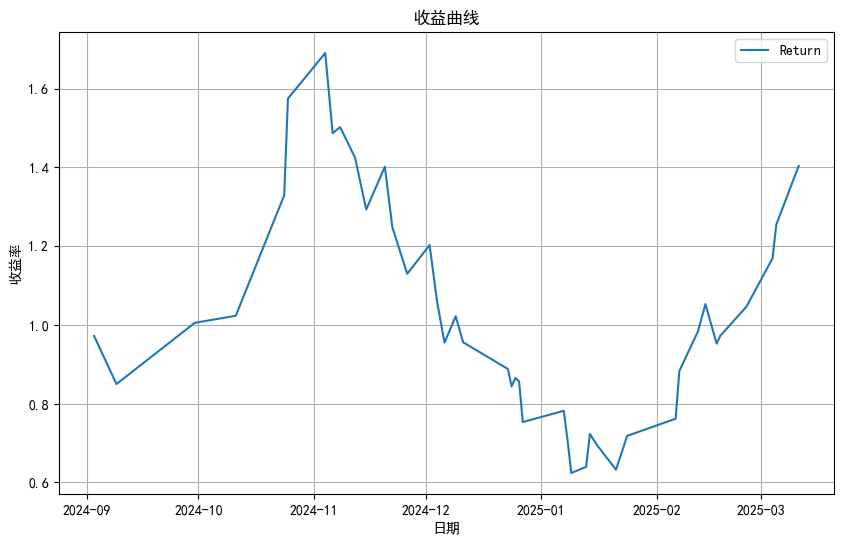

In [ ]:
plot(ddwndx, 'cumulative_returns')

In [ ]:
dwndx['r_pct'] = dwndx['real_open']/dwndx['open_price']

C:\Users\Administrator\AppData\Local\Temp\ipykernel_18592\2979096706.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dwndx['r_pct'] = dwndx['real_open']/dwndx['open_price']


In [ ]:
pd.set_option('display.max_columns', None)
dwndx.sort_values(by='r_pct', ascending=False)

,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,created_at,first_tick_amount,return,real_return,close_return,close_real_return,close_1,low_1,close_2,low_2,close_3,low_3,close_4,low_4,close_5,low_5,close_6,low_6,close_7,low_7,close_8,low_8,close_9,low_9,close_10,low_10,real_open,r_return,cumulative_returns,r_pct
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-12-23,1462,低吸,连断低吸,600255.XSHG,鑫科材料,2,,,,-1,-1,-1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0.0,977.10,465.79,0.0,-2.67,4.01,3.71,-1.0,3.70,3.86,-1.0,-1.0,-1.0,-1.0,0,0,9G0033,连断低吸,-90.07,-9.72,73,-4.95,-0.88,43,2025-02-15 19:12:11,170922641.0,-0.077307,-0.078307,-0.037406,-0.038406,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,4.15,-0.070880,0.888018,1.034913
2025-01-07,367,低吸,连断低吸,002397.XSHE,梦洁股份,1,,,,-1,-1,-1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0.0,773.22,513.57,0.0,-0.53,3.74,4.14,-1.0,4.11,4.02,-1.0,-1.0,-1.0,-1.0,0,0,9G0033,连断低吸,-112.81,-3.79,66,-92.31,-24.43,55,2025-02-15 19:24:08,37238259.0,0.098930,0.097930,0.074866,0.073866,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,3.87,0.037760,0.781780,1.034759
2024-11-20,1215,低吸,连断低吸,002757.XSHE,南兴股份,2,"000003.BKDL,000026.BKDL,000023.BKDL,000006.BKD...","885459.DDBK,885930.DDBK,885957.DDBK,885517.DDB...",980365.ZHBK,2,1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0.0,834.66,511.08,0.0,-8.55,17.00,20.45,-1.0,19.80,19.00,-1.0,-1.0,-1.0,-1.0,0,0,9G0033,连断低吸,-34.46,17.49,50,96.32,13.47,7,2025-02-15 18:41:19,88096176.0,0.164706,0.163706,0.117647,0.116647,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,17.51,0.084094,1.401688,1.030000
2025-03-04,518,低吸,连断低吸,605100.XSHG,华丰股份,1,"000003.BKDL,000024.BKDL,000023.BKDL,000035.BKD...","885869.DDBK,885887.DDBK,885706.DDBK,885946.DDB...",980365.ZHBK,1,1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0.0,436.78,453.39,0.0,-4.35,22.00,25.30,-1.0,25.00,25.32,-1.0,-1.0,-1.0,-1.0,0,0,9G0033,连断低吸,-117.41,-29.54,57,-49.79,-8.35,51,2025-03-05 08:00:57,40517048.0,0.136364,0.135364,0.150909,0.149909,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,22.64,0.117375,1.169221,1.029091
2024-11-12,842,低吸,连断低吸,600619.XSHG,海立股份,1,,,,-1,-1,-1,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0.0,1641.13,1619.06,0.0,-4.50,18.90,20.47,-1.0,19.03,18.42,-1.0,-1.0,-1.0,-1.0,0,0,9G0033,连断低吸,-2.62,-46.55,54,126.39,-12.22,8,2025-02-15 18:34:01,362169360.0,0.006878,0.005878,-0.025397,-0.026397,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,19.40,-0.051515,1.424805,1.026455
2024-12-06,535,低吸,连断低吸,002689.XSHE,远大智能,2,"000026.BKDL,000035.BKDL,000034.BKDL,000013.BKD...","885641.DDBK,885517.DDBK,885783.DDBK,885941.DDB...",980365.ZHBK,1,1,3,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,158.96,264.18,0.0,-2.89,4.70,4.45,-1.0,4.25,4.34,-1.0,-1.0,-1.0,-1.0,0,0,9G0033,连断低吸,-17.33,45.44,50,31.68,4.49,32,2025-02-15 18:57:23,33180477.0,-0.095745,-0.096745,-0.076596,-0.077596,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,4.81,-0.098713,0.954905,1.023404
2024-09-30,1636,低吸,连断低吸,002583.XSHE,海能达,1,"000008.BKDL,000026.BKDL,000018.BKDL,000023.BKD...","885840.DDBK,885757.DDBK,885521.DDBK,885574.DDB...",980376.ZHBK,1,1,67,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,879.

<Axes: ylabel='Frequency'>

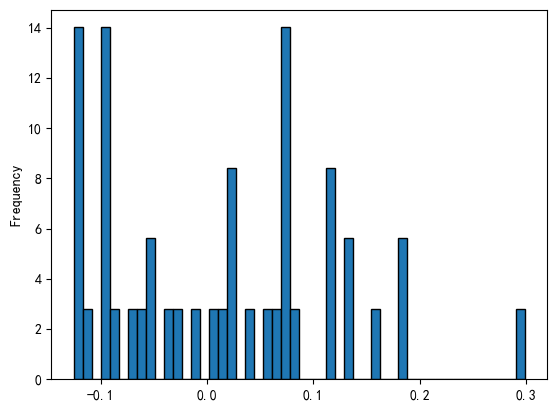

In [ ]:
ddwndx['r_return'].plot(kind='hist', bins=50, density=True, edgecolor='black')

In [ ]:
# 最大回撤: -14.59%
# 夏普比率: 0.29
# 总收益率: 234.78%
# 年化收益率: 722.40%
# 波动率: 5.95%
# 总盈亏: 235.83%
# 成功次数: 48
# 失败次数: 30
# 总天数: 78
# 总交易次数: 78
# 交易频率: 100.00%
# 胜率: 61.54%
# 平均盈利: 4.61%
# 平均亏损: -2.89%
# 最大盈利: 23.18%
# 最大亏损: -9.73%
# 盈亏比: 1.60
# 凯利公式最佳仓位: 37.43%

In [ ]:
# return:
# 最大回撤: -14.59%
# 夏普比率: 0.28
# 总收益率: 192.71%
# 年化收益率: 690.29%
# 波动率: 6.32%
# 总盈亏: 194.90%
# 成功次数: 41
# 失败次数: 26
# 总天数: 67
# 总交易次数: 67
# 交易频率: 100.00%
# 胜率: 61.19%
# 平均盈利: 4.87%
# 平均亏损: -3.05%
# 最大盈利: 23.18%
# 最大亏损: -9.73%
# 盈亏比: 1.60
# 凯利公式最佳仓位: 36.91%

In [ ]:
# return:
# 最大回撤: -27.17%
# 夏普比率: 0.31
# 总收益率: 62.21%
# 年化收益率: 746.54%
# 波动率: 9.29%
# 总盈亏: 63.20%
# 成功次数: 13
# 失败次数: 7
# 总天数: 20
# 总交易次数: 20
# 交易频率: 100.00%
# 胜率: 65.00%
# 平均盈利: 8.77%
# 平均亏损: -8.12%
# 最大盈利: 15.90%
# 最大亏损: -12.06%
# 盈亏比: 1.08
# 凯利公式最佳仓位: 32.59%
